# Use Case Trans Effects

## ARID1A Mutation Trans Effect on Proteomics

This use case will showcase the effects of ARID1A mutation, first on interacting proteins and then with a list of other proteins in endometrial and colon cancer. While we are only working with these two, the strategies shown here are easily applicable across the many other types of cancer data found in the CPTAC package.

# Step 1: Import Libraries

Here we will import standard python libraries used to analyze and visualize data as pandas dataframes.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Import CPTAC data

In [2]:
import cptac
import cptac.utils as al

Here we define the datesets we will work with in this use case, endometrial and colon cancer.

In [3]:
en = cptac.Endometrial()
co = cptac.Colon()

Now we identify the gene we will work with. For this case, we will use ARID1A

In [4]:
gene = "ARID1A"

In this use case we want to see how our gene's mutation affects proteins that interact with it, so we will use proteomics. You can easily decide to analyze transcriptomics, phosphoproteomics, or acetylproteomics by changing the value of "omics."

In [5]:
omics = "proteomics"
#omics = "transcriptomics"
#omics = "phosphoproteomics"
#omics = "acetylproteomics"

# Step 2: Set up Dataframe

Here we want to create a new dataframe that we will populate with proteins that statistically prove to be affected by the ARID1A mutation. We start by labeling the dataframe column names, getting it ready to add our list of proteins.

In [6]:
all_significant_comparisons = pd.DataFrame(columns=['Cancer_Type', 'Gene', 'Comparison','Interacting_Protein','P_Value'])

In [7]:
all_significant_comparisons.head()

,Cancer_Type,Gene,Comparison,Interacting_Protein,P_Value


Here we define a function that we will call to add the desired proteins and their corresponding relevant information to our dataframe.

In [8]:
def add_to_all_significant_comparisons(df, cancer, interacting, all_sig_comp):
    expanded = df
    expanded['Gene'] = gene
    expanded['Cancer_Type'] = cancer
    expanded['Interacting_Protein'] = interacting
    
    updated_all_comparisons = pd.concat([all_sig_comp, expanded], sort=False)
    
    return updated_all_comparisons

# Step 3: Get Interacting Proteins

Now we will get a list of the proteins that are know to interact with ARID1A. We start with these because they have a high probability of being affected by a mutation because of their close contact. In this case we use the bioplex method

In [9]:
interacting_proteins = al.get_interacting_proteins_bioplex(gene)

print("Interacting Proteins:")
for interacting_protein in interacting_proteins:
    print(interacting_protein)

Interacting Proteins:
SS18
BCL7A
SMARCE1
DPF2
SMARCC2
BCL7C
SMARCD1
DPF3


### Test for significant comparisons in any of interacting proteins

# Step 3: Run T-tests to find significant comparisons

### Endometrial

Now we create a new dataframe containing protein measurements for the interacting proteins that we are interested in. This is done with endometrial cancer, but as mentioned earlier can be done for other cancers. An example with colon cancer will be shown later.

In [10]:
protdf = en.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=omics, omics_genes=interacting_proteins)
protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']

Next, since in order to make comparisons we will want our "Label" column to contain one of two values- either "Mutated" or "Wildtype."

In [11]:
for ind, row in protdf.iterrows():
    if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
        protdf.at[ind,'Label'] = 'Mutated'
    else:
        protdf.at[ind,'Label'] = 'Wildtype'

In [12]:
protdf.head()

Name,SS18_proteomics,BCL7A_proteomics,SMARCE1_proteomics,DPF2_proteomics,SMARCC2_proteomics,BCL7C_proteomics,SMARCD1_proteomics,DPF3_proteomics,ARID1A_Mutation,ARID1A_Location,ARID1A_Mutation_Status,Sample_Status,Label
Sample_ID,,,,,,,,,,,,,
S001,-0.498,0.4100,-0.3950,-0.548,-0.451,-0.9180,-0.328,NaN,[Missense_Mutation],[p.T2121P],Single_mutation,Tumor,Mutated
S002,-0.162,0.8880,-0.5560,-0.919,-0.627,-0.9410,-0.418,NaN,"[Nonsense_Mutation, Frame_Shift_Del]","[p.Q403*, p.D1850Tfs*33]",Multiple_mutation,Tumor,Mutated
S003,-0.448,0.0927,-0.5400,-0.555,-0.537,-0.3880,-0.648,NaN,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor,Wildtype
S005,0.203,0.6880,0.0968,0.372,-0.102,-0.0328,0.186,NaN,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor,Wildtype
S006,0.298,0.3460,0.0897,-0.642,-0.432,-1.4000,-0.599,NaN,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor,Wildtype


Since we are only interested in interacting protein levels, here we trim down the dataframe and drop unwanted columns.

In [13]:
protdf = protdf.drop(gene+"_Mutation",axis=1)
protdf = protdf.drop(gene+"_Location",axis=1)
protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
protdf = protdf.drop("Sample_Status",axis=1)

In [14]:
protdf.head()

Name,SS18_proteomics,BCL7A_proteomics,SMARCE1_proteomics,DPF2_proteomics,SMARCC2_proteomics,BCL7C_proteomics,SMARCD1_proteomics,DPF3_proteomics,Label
Sample_ID,,,,,,,,,
S001,-0.498,0.4100,-0.3950,-0.548,-0.451,-0.9180,-0.328,NaN,Mutated
S002,-0.162,0.8880,-0.5560,-0.919,-0.627,-0.9410,-0.418,NaN,Mutated
S003,-0.448,0.0927,-0.5400,-0.555,-0.537,-0.3880,-0.648,NaN,Wildtype
S005,0.203,0.6880,0.0968,0.372,-0.102,-0.0328,0.186,NaN,Wildtype
S006,0.298,0.3460,0.0897,-0.642,-0.432,-1.4000,-0.599,NaN,Wildtype


We take the column names, which are the interacting proteins, and create a list in order to run our t-tests for each protein individually.

In [15]:
col_list = list(protdf.columns)
col_list.remove('Label')

In [16]:
print(col_list)

['SS18_proteomics', 'BCL7A_proteomics', 'SMARCE1_proteomics', 'DPF2_proteomics', 'SMARCC2_proteomics', 'BCL7C_proteomics', 'SMARCD1_proteomics', 'DPF3_proteomics']


Now we run our t-test algorithm from cptac.utils which will return to us a dataframe with any comparisons values that reach an adjusted threshold. These proteins are the ones that are significantly affected by the ARID1A mutation.

In [17]:
print("Doing t-test comparisons\n")

wrap_results = al.wrap_ttest(protdf, 'Label', col_list)

if wrap_results is not None:
        print(wrap_results)
        print("\n\n")
        
        all_significant_comparisons = add_to_all_significant_comparisons(wrap_results, "Endometrial", True, all_significant_comparisons)



Doing t-test comparisons

           Comparison       P_Value
0     DPF2_proteomics  2.166609e-07
1  SMARCC2_proteomics  8.270473e-05
2  SMARCE1_proteomics  1.498027e-04
3  SMARCD1_proteomics  1.744915e-04
4    BCL7C_proteomics  4.379537e-04





### Colon

Here we follow the same steps that we took for endometrial cancer, but this time with colon cancer.

In [18]:
'''Create dataframe in order to do comparisons with wrap_ttest'''
protdf = co.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=omics, omics_genes=interacting_proteins)
protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']

'''Create the binary valued column needed to do the comparison'''
for ind, row in protdf.iterrows():
    if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
        protdf.at[ind,'Label'] = 'Mutated'
    else:
        protdf.at[ind,'Label'] = 'Wildtype'

'''Format the dataframe correctly'''
protdf = protdf.drop(gene+"_Mutation",axis=1)
protdf = protdf.drop(gene+"_Location",axis=1)
protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
protdf = protdf.drop("Sample_Status",axis=1)

'''Make list of columns to be compared using t-tests'''
col_list = list(protdf.columns)
col_list.remove('Label')

print("Doing t-test comparisons\n")

'''Call wrap_ttest, pass in formatted dataframe'''
wrap_results = al.wrap_ttest(protdf, 'Label', col_list)

'''Print results, if anything significant was found'''
if wrap_results is not None:
        print(wrap_results)
        print("\n\n")
        
        all_significant_comparisons = add_to_all_significant_comparisons(wrap_results, "Colon", True, all_significant_comparisons)


Doing t-test comparisons

No significant comparisons.


Since no significant comparisons were found in colon cancer, no proteins or values were added to our overall dataframe.

# Step 4: Find significant comparisons among all proteins

### Endometrial

Now that we have found significant values among interacting proteins, we will now go through the rest of the proteins in the CPTAC dataset and find any more that were significantly changed because of a mutation in ARID1A. The reason for doing two separate comparisons is because of the threshold used by wrap_ttest. The value is adjusted to be smaller and smaller as more proteins in a set are analyzed, as we use the formula of (.05 / number of proteins). Here we will once again go through the same t-testing steps from earlier, but this time without specifying specific proteins.

In [19]:
try:
    print("\nGene: ", gene)

    '''Use all proteins'''

    '''Create dataframe in order to do comparisons with wrap_ttest'''
    protdf = en.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=omics) #Here is the different line
    protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']
    
    '''Create the binary valued column needed to do the comparison'''
    for ind, row in protdf.iterrows():
        if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
            protdf.at[ind,'Label'] = 'Mutated'
        else:
            protdf.at[ind,'Label'] = 'Wildtype'

    '''Format the dataframe correctly'''
    protdf = protdf.drop(gene+"_Mutation",axis=1)
    protdf = protdf.drop(gene+"_Location",axis=1)
    protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
    protdf = protdf.drop("Sample_Status",axis=1)

    '''Make list of columns to be compared using t-tests'''
    col_list = list(protdf.columns)
    col_list.remove('Label')

    print("Doing t-test comparisons\n")
    
    '''Call wrap_ttest, pass in formatted dataframe'''
    wrap_results = al.wrap_ttest(protdf, 'Label', col_list)

    '''Print results, if anything significant was found'''
    if wrap_results is not None:
            print(wrap_results)
            print("\n\n")
            
            all_significant_comparisons = add_to_all_significant_comparisons(wrap_results, "Endometrial", False, all_significant_comparisons)


except Exception as e:
    print("Error in Comparison")
    print(e)


Gene:  ARID1A


Doing t-test comparisons

          Comparison       P_Value
0  ARID1A_proteomics  1.025018e-10
1   MAP1S_proteomics  1.010149e-07
2    DPF2_proteomics  2.166609e-07
3   KDM4B_proteomics  4.414547e-07
4    RRM1_proteomics  4.455870e-07
5  MAP7D3_proteomics  4.880890e-07
6   CYTH3_proteomics  3.109396e-06
7   CEP78_proteomics  3.749172e-06





### Colon

Now we do the same thing for colon samples.

In [20]:
try:
    print("\nGene: ", gene)
    
    '''Use all proteins'''
    '''Create dataframe in order to do comparisons with wrap_ttest'''
    protdf = co.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=omics)
    protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']
    
    '''Create the binary valued column needed to do the comparison'''
    for ind, row in protdf.iterrows():
        if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
            protdf.at[ind,'Label'] = 'Mutated'
        else:
            protdf.at[ind,'Label'] = 'Wildtype'

    '''Format the dataframe correctly'''
    protdf = protdf.drop(gene+"_Mutation",axis=1)
    protdf = protdf.drop(gene+"_Location",axis=1)
    protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
    protdf = protdf.drop("Sample_Status",axis=1)

    '''Make list of columns to be compared using t-tests'''
    col_list = list(protdf.columns)
    col_list.remove('Label')

    print("Doing t-test comparisons\n")
    
    '''Call wrap_ttest, pass in formatted dataframe'''
    wrap_results = al.wrap_ttest(protdf, 'Label', col_list)

    '''Print results, if anything significant was found'''
    if wrap_results is not None:
            print(wrap_results)
            print("\n\n")
            
            all_significant_comparisons = add_to_all_significant_comparisons(wrap_results, "Colon", False, all_significant_comparisons)


except Exception as e:
    print("Error in Comparison")
    print(e)


Gene:  ARID1A


Doing t-test comparisons

No significant comparisons.


# Step 5: Analyze collected proteins

First we will print our dataframe containing the affected proteins that we found. Note that ARID1A_proteomics has the smallest P-Value and is therefore the most affected, as expected since we are analyzing a mutation in ARID1A itself.

In [21]:
if len(all_significant_comparisons) > 0:
    display(all_significant_comparisons)
    
else:
    print('No Significant Comparisons!')

,Cancer_Type,Gene,Comparison,Interacting_Protein,P_Value
0,Endometrial,ARID1A,DPF2_proteomics,True,2.166609e-07
1,Endometrial,ARID1A,SMARCC2_proteomics,True,8.270473e-05
2,Endometrial,ARID1A,SMARCE1_proteomics,True,1.498027e-04
3,Endometrial,ARID1A,SMARCD1_proteomics,True,1.744915e-04
4,Endometrial,ARID1A,BCL7C_proteomics,True,4.379537e-04
0,Endometrial,ARID1A,ARID1A_proteomics,False,1.025018e-10
1,Endometrial,ARID1A,MAP1S_proteomics,False,1.010149e-07
2,Endometrial,ARID1A,DPF2_proteomics,False,2.166609e-07
3,Endometrial,ARID1A,KDM4B_proteomics,False,4.414547e-07
4,Endometrial,ARID1A,RRM1_proteomics,False,4.455870e-07


#### Example analysis using DPF2

Now we want to create and trim down a dataframe in order to have our desired protein levels for each sample, along with a label as to whether it is a mutated or wildtype sample.

In [22]:
protdf = en.join_omics_to_mutations(omics_df_name='proteomics',omics_genes='DPF2',mutations_genes='ARID1A')
protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']

'''Create the binary valued column needed to do the comparison'''
for ind, row in protdf.iterrows():
    if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
        protdf.at[ind,'Label'] = 'Mutated'
    else:
        protdf.at[ind,'Label'] = 'Wildtype'

'''Format the dataframe correctly'''
protdf = protdf.drop(gene+"_Mutation",axis=1)
protdf = protdf.drop(gene+"_Location",axis=1)
protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
protdf = protdf.drop("Sample_Status",axis=1)

protdf.head()

Name,DPF2_proteomics,Label
Sample_ID,,
S001,-0.548,Mutated
S002,-0.919,Mutated
S003,-0.555,Wildtype
S005,0.372,Wildtype
S006,-0.642,Wildtype


Now we will plot our data using the seaborn library as a stripplot on top of a boxplot in order to see the distributions.

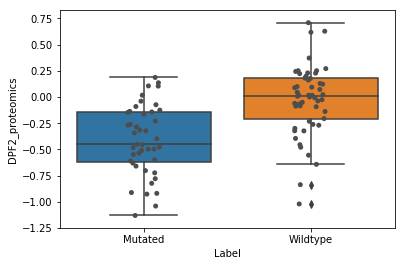

In [23]:
sns.boxplot(data = protdf, x = 'Label', y = 'DPF2_proteomics')
sns.stripplot(data = protdf, x = 'Label', y = 'DPF2_proteomics', jitter = True, dodge = True, color = '.3')